# CS313E Term Project

## Part 1: Project Proposal

#### 1. What is your project idea about?

The plan for our project is to web-scrape data from Wikipedia, and build a binary search tree with the data to allow easy sorting and search. Finally, we will will list a few statistical analyses made from our sorted data.

#### 2. If you use any datasets, describe the dataset and provide how one can access and download it.

We plan on sourcing our data from the Wikipedia page for [recorded Category 5 Atlantic Hurricanes.](https://en.wikipedia.org/wiki/List_of_Category_5_Atlantic_hurricanes) Anyone can access it and we will retreive the data using APIs.

#### 3. Describe your design for main packages, classes, methods, functions, and iterations between them.

Our program will be made in Jupyter notebook, with each "section" of the project separated by cells. For example, one cell will include the web-scraping, another will include the creation of the binary tree and its constituent functions, and one for the calling all the functions. We plan on creating one function to handle the web-scraping, and two classes to be our implementation of the node and tree classes of a binary search tree.

#### 4. Describe any libraries that you use.

We will be using the BeautifulSoup API and the Requests API to ensure Wikipedia allows us to scrape the data and then subsequently scrape it.

#### 5. Design some Test cases that can test the correctness of your software.

To ensure the Binary Search Tree was properly constructed, we plan on creating a search function to find specific pieces of data and ensure they are within the tree, as well as outputting a sorted list of data to ensure the hurricane data was properly sorted.

#### 6. What is your current expectations of your software? For example, do you expect that it works well? What are the expected weaknesses?

We assume we will run into some hiccups with properly web-scraping the data, as well as cleaning the data before loading it into the binary tree. We also plan on loading our data as dictionary values, which we haven't done before with binary trees. Once the data is properly loaded and the tree is built, we expect the rest of the program to be relatively simple.

## Part 2: Implementation

In [ ]:
#Import packages needed to extract, load, and transform data
from bs4 import BeautifulSoup
import requests
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pprint as pp
import seaborn as sns

In [ ]:
def get_data_dict():

  #Grab url to scrape data from
  url = 'https://en.wikipedia.org/wiki/List_of_Category_5_Atlantic_hurricanes'
  opened_webpage = requests.get(url)
  bs = BeautifulSoup(opened_webpage.content, "html.parser")

  #Find table data to scrape
  tables = bs.findAll('table', {'class':"wikitable sortable"})
  wiki_table = str(tables[0])

  #Convert to dataframe
  df = pd.read_html(str(wiki_table))
  df = pd.DataFrame(df[0])

  #Cut out unnecessary columns
  df = df[['Name', 'Deaths', 'Peak\xa0intensity', 'Dates at Category 5 intensity', "Duration at Category 5 intensity"]]
  #Rename remaining columns
  df.columns = ['Name', 'Deaths', 'Wind speed (MPH)', 'Pressure (hPA)', 'Date', "Duration at Category 5 intensity"]
  #Clean column data to be purely numeric - except name
  df['Wind speed (MPH)'] = df['Wind speed (MPH)'].str.split().str[0]
  df['Pressure (hPA)'] = df['Pressure (hPA)'].str.split().str[0]
  df['Year'] = df['Date'].str.split().str[-1]
  df['Month'] = df['Date'].str.split().str[0]
  df['Year'] = df['Year'].str.split('[').str[0]
  for i, v in enumerate(df['Duration at Category 5 intensity']):
      duration = v.split()
      if 'day' in v:
          #print(i.split())
          if 'hours' not in v:
              v = str(int(duration[0]) * 24)
              df.loc[i, 'Duration at Category 5 intensity'] = v
          else:
              v = str( int(duration[0]) * 24 + int(duration[2]) )
              df.loc[i, 'Duration at Category 5 intensity'] = v
      else:
          v = duration[0]
          df.loc[i, 'Duration at Category 5 intensity'] = v

  df = df.drop(columns=['Date'])

  #Convert to 2d dictionary.
  #Each key refers a row value, and column values can be input as keys in each row to retreive the specific value
  dictionary = df.to_dict('index')
  return df, dictionary

In [ ]:
#I'll delete this cell soon - just showing the data
df, data_dict = get_data_dict()
print(df)

In [ ]:
#Import the binary search tree class
#Link to github: https://github.com/kiat/Elements-of-Software-Design/blob/main/example_009_binary_search_tree.py
import example_009_binary_search_tree as bst

class Dict_Tree():
    def __init__(self, data_dict, name_col, numeric_cols):
        '''
        Takes in our 2d dict, a name column, and a list of numeric columns.
        For our program, name_col refers to the hurricane names, and
        numeric_cols refers to the numeric data (deaths, wind speed, pressure, year)
        '''
        self.name_col = name_col
        self.numeric_cols = numeric_cols

        self.trees = []
        self.data_dict = data_dict

        # Iterate through every numeric column, and create a bst that stores its values in a tree.
        # Append each created tree to self.trees
        for columns in numeric_cols:
            new_bst = bst.BST()

            for rows in self.data_dict:
                new_bst.insert(self.data_dict[rows][columns])
            self.trees.append(new_bst)


    def get_tuple_dict(self):
        total_cols = [self.name_col] + self.numeric_cols

        tuple_dict = [tuple(total_cols)]

        for i in data_dict:
          row = []
          for key in total_cols:
            row.append(data_dict[i][key])
          tuple_dict.append(tuple(row))
        return tuple_dict

    def sort_by(self, column):
        '''
        Creates a dictionary that is sorted by a given numeric column.
        Key - Name (Hurricane name)
        Value - Given numeric column (Deaths, Wind speed, etc.)
        '''

        #If the given column is not in our list of numeric cols, return invalid
        if column not in self.numeric_cols:
            return 'Invalid column name'

        # Empty list that will eventually contain our list of tuples
        sorted_list = []
        # Get the index of the tree we want to access
        tree_index = self.numeric_cols.index(column)
        # Get the BST tree
        tree = self.trees[tree_index]
        # Get the sorted values in the BST via inorder traversal
        sorted_vals = self.in_order(tree.root)

        # Get the tuple dict
        tuple_dict = self.get_tuple_dict()
        #Grab the list of all columns and the index value of the current column in the list
        tuple_index = tuple_dict[0].index(column)

        #Append the list of all columns to our sorted_list. Basically the header of our data
        sorted_list.append(tuple_dict[0])

        # Loop through our sorted values and the tuple dict.
        # If the sorted value is inside the tuple_dict, add it to the sorted list
        for value in sorted_vals:
            for row in tuple_dict[1:]:

                # if value == row[tuple_index] is used instead of if value in row so
                # we don't check other columns' values and cause potential errors
                if value == row[tuple_index] and row not in sorted_list:
                    sorted_list.append(row)


        #Return our sorted dictionary (technically its a list of tuples)
        return sorted_list

    #Calls sort_by on every numeric column and prints neatly.
    def print_all(self):
        format_string = "{:<30}" * 5
        for i in self.numeric_cols:
            print(f'Dictionary sorted by {i}:')
            table = self.sort_by(i)
            for _, j in enumerate(table):

                print(format_string.format(*j))

                if _ == 0:
                  print()

            print('\n \n \n')

    def in_order(self, a_node):
        '''In-order traversal - left, right, center.
           We pass in a list and use the helper function _in_order to do the actual traversal.
        '''
        in_expression = []
        self._in_order(a_node, in_expression)
        return in_expression

    def _in_order(self, a_node, in_expression):
        if a_node is None:
            return
        self._in_order(a_node.lChild, in_expression)
        in_expression.append(a_node.key)
        self._in_order(a_node.rChild, in_expression)
        return

In [ ]:
death_tree = Dict_Tree(data_dict, 'Name', ['Deaths', 'Wind speed (MPH)', 'Pressure (hPA)', 'Year'])
print(death_tree.get_tuple_dict())
death_tree.print_all()

[('Name', 'Deaths', 'Wind speed (MPH)', 'Pressure (hPA)', 'Year'), ('"Cuba"', 90, '165', '910', '1924'), ('"San Felipe II Okeechobee"', 4000, '160', '929', '1928'), ('"Bahamas"', 16, '160', '921', '1932'), ('"Camagüey"', 3103, '175', '915', '1932'), ('"Cuba–Brownsville"', 179, '160', '930', '1933'), ('"Tampico"', 184, '160', '929', '1933'), ('"Labor Day"', 408, '185', '892', '1935'), ('"New England"', 682, '160', '940', '1938'), ('"Great Atlantic"', 300, '160', '918', '1944'), ('Carol', 5, '160', '929', '1953'), ('Janet', 1023, '175', '914', '1955'), ('Esther', 7, '160', '919', '1961'), ('Hattie', 319, '165', '914', '1961'), ('Inez', 756, '165', '927', '1966'), ('Beulah', 59, '160', '921', '1967'), ('Camille', 259, '175', '900', '1969'), ('Edith', 37, '160', '943', '1971'), ('Anita', 11, '175', '926', '1977'), ('David', 2068, '175', '924', '1979'), ('Allen', 269, '190', '899', '1980'), ('Gilbert', 318, '185', '888', '1988'), ('Hugo', 107, '160', '918', '1989'), ('Andrew', 65, '175', '9

In [ ]:
print(death_tree.sort_by('Deaths'))

[('Name', 'Deaths', 'Wind speed (MPH)', 'Pressure (hPA)', 'Year'), ('Lee', 3, '165', '926', '2023'), ('Carol', 5, '160', '929', '1953'), ('Esther', 7, '160', '919', '1961'), ('Anita', 11, '175', '926', '1977'), ('"Bahamas"', 16, '160', '921', '1932'), ('Emily', 17, '160', '929', '2005'), ('Lorenzo', 20, '160', '925', '2019'), ('Edith', 37, '160', '943', '1971'), ('Dean', 45, '175', '905', '2007'), ('Isabel', 51, '165', '915', '2003'), ('Beulah', 59, '160', '921', '1967'), ('Andrew', 65, '175', '922', '1992'), ('Michael', 74, '160', '919', '2018'), ('Dorian', 84, '185', '910', '2019'), ('Wilma', 87, '185', '882', '2005'), ('"Cuba"', 90, '165', '910', '1924'), ('Hugo', 107, '160', '918', '1989'), ('Ivan', 124, '165', '910', '2004'), ('Rita', 125, '180', '895', '2005'), ('Felix', 133, '175', '929', '2007'), ('Irma', 138, '180', '914', '2017'), ('Ian', 160, '160', '937', '2022'), ('"Cuba–Brownsville"', 179, '160', '930', '1933'), ('"Tampico"', 184, '160', '929', '1933'), ('Camille', 259, '

#Part 3: Data Visualizations

## Visualize the distributions of our number values

In [ ]:
# Plotting Freqency of Deaths by Category 5 Hurricanes
plt.figure(figsize=(12, 6))
# plotting deaths on a histogram
sns.histplot(df['Deaths'], kde=True)
plt.title('Frequency of Deaths by Category 5 Hurricanes')
plt.xlabel('Number of Deaths')
plt.show()

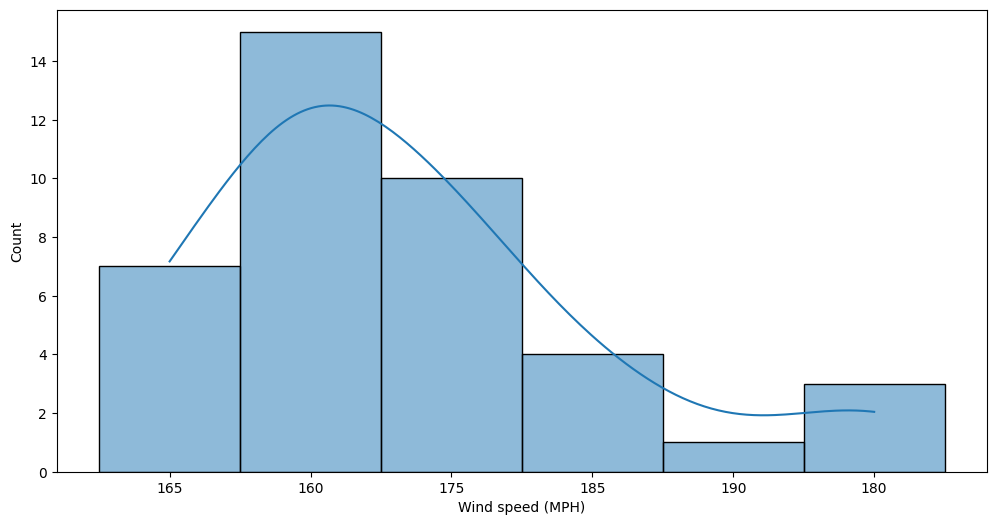

In [ ]:
# Plotting Wind speed
plt.figure(figsize=(12, 6))
sns.histplot(df['Wind speed (MPH)'], kde=True)
plt.show()

## Data Analysis Visualizations

In [ ]:
# Plotting
hurricanes_per_year = df.groupby('Year')['Deaths'].sum()
plt.figure(figsize=(12, 6))
hurricanes_per_year.plot(
    kind='area', color='skyblue'
    )

plt.title('Number of Deaths caused by Category 5 Hurricanes Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Deaths caused by Category 5 Hurricanes')
plt.show()

In [ ]:
df = df.apply(pd.to_numeric, errors='ignore')

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot =True, cmap='coolwarm')

plt.tight_layout()
plt.title('Correlation of Deaths, Wind speed, Pressure, Durration, and Year')
plt.show()

In [ ]:
# Number of deaths over the years
hurricanes_per_year = df.groupby('Year')['Deaths'].sum()
plt.figure(figsize=(12, 6))
hurricanes_per_year.plot(kind='area', color='skyblue')

plt.title('Number of Deaths caused by Category 5 Hurricanes Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Deaths caused by Category 5 Hurricanes')
plt.show()

In [ ]:
# Density Graph
df = df.apply(pd.to_numeric, errors='ignore')
plt.figure(figsize=(12, 6))

sns.kdeplot(x = df['Wind speed (MPH)'], y = df['Pressure (hPA)'], cmap="Reds", fill=True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.regplot(x = 'Wind speed (MPH)', y = 'Pressure (hPA)', data = df)
plt.tight_layout()
plt.title('Relationship between Pressure and Wind Speed')
plt.show()